In [ ]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as preprocess_mobilenet
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import spacy

# Define paths
train_images_path1 = '/content/drive/MyDrive/train'
train_images_path2 = '/content/drive/MyDrive/train2'
valid_images_path = '/content/drive/MyDrive/valid'
test_images_path = '/content/drive/MyDrive/test'
train_annotations_path1 = '/content/train_combined.json'
train_annotations_path2 = '/content/train2_combined.json'
valid_annotations_path = '/content/valid_combined.json'
test_annotations_path = '/content/test_combined.json'

In [ ]:
def load_annotations(file_path):
    with open(file_path, 'r') as file:
        annotations = json.load(file)
    return annotations

# Load annotations
train_annotations1 = load_annotations(train_annotations_path1)
train_annotations2 = load_annotations(train_annotations_path2)
valid_annotations = load_annotations(valid_annotations_path)
test_annotations = load_annotations(test_annotations_path)

In [ ]:
def load_images(directory, target_size=(224, 224)):
    images = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isdir(img_path):
            continue
        try:
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            img = img / 255.0  # Normalize image
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    return np.array(images)

def extract_features_with_mobilenet(directory):
    model = MobileNetV2(include_top=False, pooling='avg')
    features = {}
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        if os.path.isdir(img_path):
            continue
        try:
            img = load_img(img_path, target_size=(224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = preprocess_mobilenet(img)

            feature = model.predict(img, verbose=0)
            features[img_name] = feature.flatten()
        except Exception as e:
            print(f"Error extracting features for image {img_path}: {e}")

    return features

# Extract features
train_features1 = extract_features_with_mobilenet(train_images_path1)
train_features2 = extract_features_with_mobilenet(train_images_path2)
valid_features = extract_features_with_mobilenet(valid_images_path)
test_features = extract_features_with_mobilenet(test_images_path)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def flatten_annotations(annotations):
    flattened_annotations = []
    for img_annotations in annotations:
        for annotation in img_annotations:
            flattened_annotations.append(annotation)
    return flattened_annotations

def preprocess_annotations(annotations):
    questions = {}
    answers = {}
    for item in annotations:
        img_path = item['image_path']
        img_name = os.path.basename(img_path)
        if img_name not in questions:
            questions[img_name] = []
        if img_name not in answers:
            answers[img_name] = []
        questions[img_name].append('startseq ' + item['Q'] + ' endseq')
        answers[img_name].append('startseq ' + item['A'] + ' endseq')
    return questions, answers

# Flatten and preprocess annotations
train_annotations1_flat = flatten_annotations(train_annotations1)
train_annotations2_flat = flatten_annotations(train_annotations2)
valid_annotations_flat = flatten_annotations(valid_annotations)
test_annotations_flat = flatten_annotations(test_annotations)

train_questions1, train_answers1 = preprocess_annotations(train_annotations1_flat)
train_questions2, train_answers2 = preprocess_annotations(train_annotations2_flat)
valid_questions, valid_answers = preprocess_annotations(valid_annotations_flat)
test_questions, test_answers = preprocess_annotations(test_annotations_flat)

In [ ]:
all_text = [item for sublist in [train_questions1.values(), train_answers1.values(), train_questions2.values(), train_answers2.values(), valid_questions.values(), valid_answers.values(), test_questions.values(), test_answers.values()] for item in sublist]
all_text_flat = [text for sublist in all_text for text in sublist]

# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text_flat)

# Adding special tokens
tokenizer.word_index['startseq'] = len(tokenizer.word_index) + 1
tokenizer.word_index['endseq'] = len(tokenizer.word_index) + 1
vocab_size = len(tokenizer.word_index) + 1

# Maximum length of questions/answers
max_length = max(len(desc.split()) for desc in all_text_flat)

In [ ]:
def create_qa_sequences(tokenizer, max_length, questions, answers, photos, vocab_size):
    X1, X2, y = [], [], []
    for key, question_list in questions.items():
        if key not in photos:
            continue
        photo = photos[key]
        for i, question in enumerate(question_list):
            seq_q = tokenizer.texts_to_sequences([question])[0]
            seq_a = tokenizer.texts_to_sequences([answers[key][i]])[0]
            for j in range(1, len(seq_a)):
                in_seq_q, in_seq_a, out_seq = seq_q, seq_a[:j], seq_a[j]
                in_seq_q = pad_sequences([in_seq_q], maxlen=max_length)[0]
                in_seq_a = pad_sequences([in_seq_a], maxlen=max_length)[0]
                if out_seq < vocab_size:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(np.concatenate([in_seq_q, in_seq_a]))
                    y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Create sequences
X1train, X2train, ytrain = create_qa_sequences(tokenizer, max_length, train_questions1, train_answers1, train_features1, vocab_size)
X1val, X2val, yval = create_qa_sequences(tokenizer, max_length, valid_questions, valid_answers, valid_features, vocab_size)

In [ ]:
def define_qa_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(1280,))  # Change the input shape to 1280
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence model for questions and answers
    inputs2 = Input(shape=(2 * max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Combine models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Define and train the model
qa_model = define_qa_model(vocab_size, max_length)
qa_model.fit([X1train, X2train], ytrain, epochs=30, batch_size=64, validation_data=([X1val, X2val], yval))

Epoch 1/30
616/616 [==============================] - 110s 164ms/step - loss: 1.3496 - val_loss: 0.7051
Epoch 2/30
616/616 [==============================] - 97s 158ms/step - loss: 0.5045 - val_loss: 0.5353
Epoch 3/30
616/616 [==============================] - 97s 157ms/step - loss: 0.3380 - val_loss: 0.4943
Epoch 4/30
616/616 [==============================] - 97s 158ms/step - loss: 0.2482 - val_loss: 0.4832
Epoch 5/30
616/616 [==============================] - 97s 157ms/step - loss: 0.1972 - val_loss: 0.4975
Epoch 6/30
616/616 [==============================] - 96s 156ms/step - loss: 0.1522 - val_loss: 0.4846
Epoch 7/30
616/616 [==============================] - 96s 155ms/step - loss: 0.1352 - val_loss: 0.4866
Epoch 8/30
616/616 [==============================] - 94s 153ms/step - loss: 0.1071 - val_loss: 0.4632
Epoch 9/30
616/616 [==============================] - 92s 149ms/step - loss: 0.0960 - val_loss: 0.5266
Epoch 10/30
616/616 [==============================] - 93s 151ms/step - 

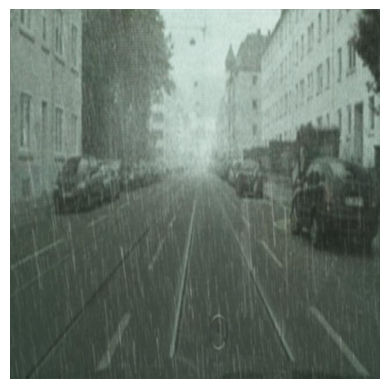

Question: startseq What is the current weather scenario? endseq
Actual Answer: startseq Heavy Rain endseq
Predicted Answer: scenario heavy rain heavy rain heavy rain heavy rain heavy rain moderate rain there are 4 objects infront of ego vehicle vehicle at footpath pedestrains infront of ego vehicle at footpath



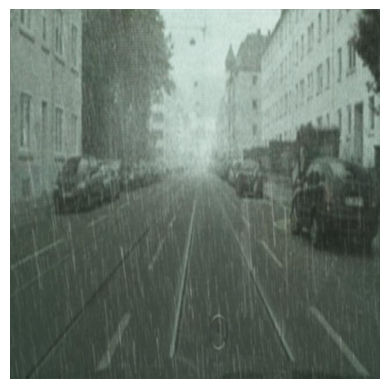

Question: startseq Please describe the current scene endseq
Actual Answer: startseq The image shows 2 cars parked to the right side of the ego vehicle, 2 cars to the right side of the ego vehicle. endseq
Predicted Answer: image shows 2 cars parked to right side of ego vehicle 2 cars to right side of ego vehicle pedestrains cars to ego vehicle at



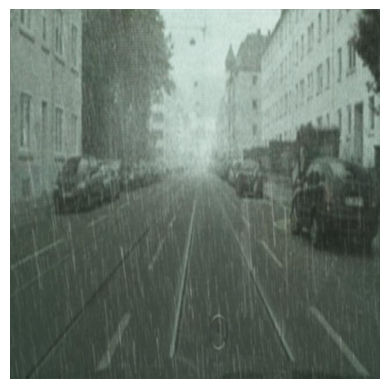

Question: startseq Are there pedestrians in front of the ego vehicle endseq
Actual Answer: startseq 0 pedestrains infront of ego vehicle at footpath. endseq
Predicted Answer: 0 pedestrains infront at footpath at footpath pedestrains at footpath pedestrains at footpath pedestrains pedestrains at footpath pedestrains at footpath



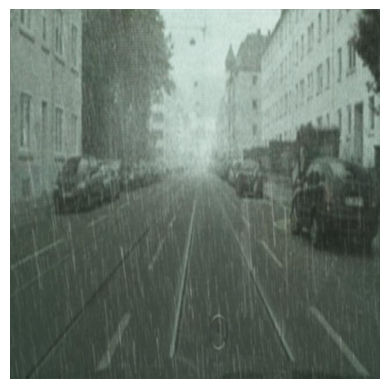

Question: startseq What are the objects in front of the ego vehicle endseq
Actual Answer: startseq There are 4 objects infront of the ego vehicle. endseq
Predicted Answer: there 4 infront at footpath pedestrains at footpath pedestrains at footpath pedestrains pedestrains at footpath pedestrains



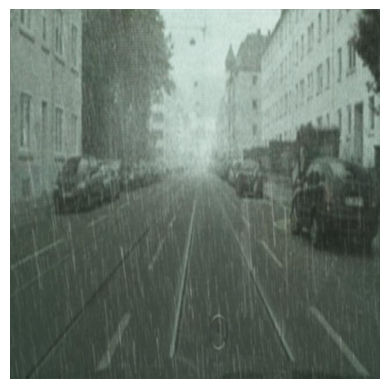

Question: startseq Are there any parking vehicles in front of the car endseq
Actual Answer: startseq There are 4 parked vehicles infront of the car endseq
Predicted Answer: 4 parked infront 4 parked infront 4 parked cars ego vehicle at right side ego



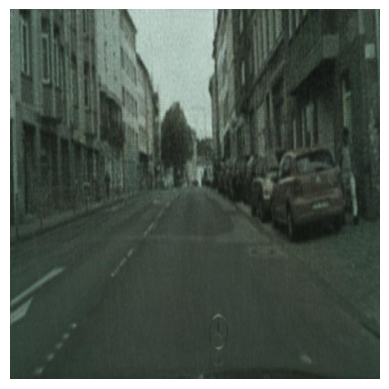

Question: startseq What is the current weather scenario? endseq
Actual Answer: startseq Cloudy endseq
Predicted Answer: scenario cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy side cloudy cloudy 0 and 0



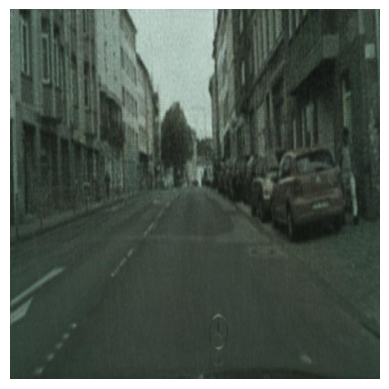

Question: startseq Please describe the current scene endseq
Actual Answer: startseq The image shows 4 cars. endseq
Predicted Answer: image shows 4 cars infront of tall buidings and 1 truck parked on road and a 4 objects to left side at some distance and 0 infront of



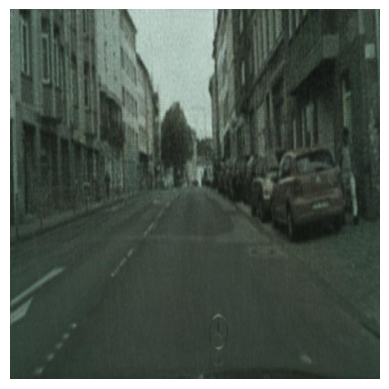

Question: startseq Are there pedestrians in front of the ego vehicle endseq
Actual Answer: startseq 0 pedestrain infront of ego vehicle at footpath. endseq
Predicted Answer: 0 pedestrain infront at footpath at footpath pedestrain infront at footpath at footpath and 0 pedestrain infront at footpath at footpath and



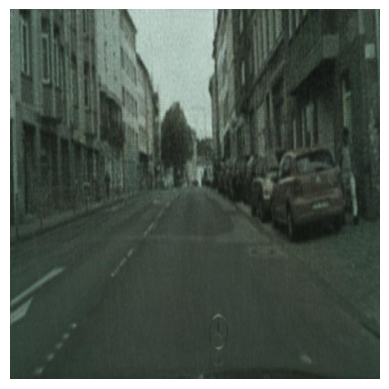

Question: startseq What are the objects in front of the ego vehicle endseq
Actual Answer: startseq There are 4 objects infront of the ego vehicle. endseq
Predicted Answer: there 4 infront at footpath pedestrain infront at footpath at footpath and 0 pedestrain infront at footpath at



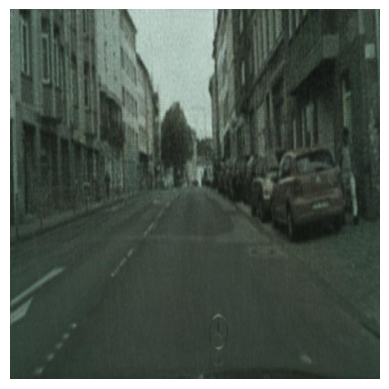

Question: startseq Are there any parking vehicles in front of the car endseq
Actual Answer: startseq There are 4 parking vehicles infront of the car endseq
Predicted Answer: 0 cars parked to left and right side objects infront and 0 vehicle infront to right side ego



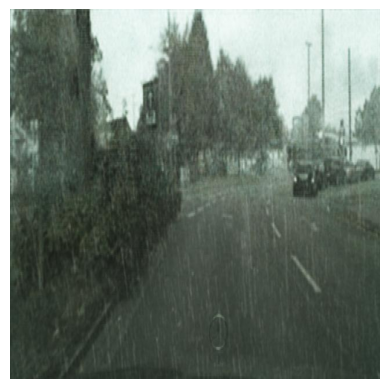

Question: startseq What is the current weather scenario? endseq
Actual Answer: startseq Moderate Rain endseq
Predicted Answer: scenario little rain little rain rain little rain rain moderate rain rain moderate rain rain image shows 3 parked cars to right and 2 cars infront of ego vehicle at



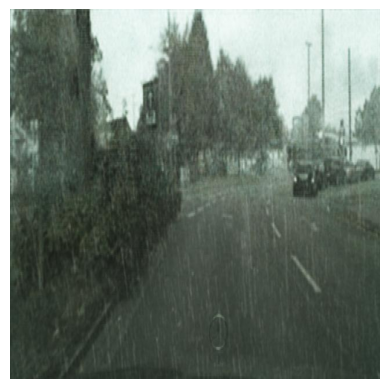

Question: startseq Please describe the current scene endseq
Actual Answer: startseq The image shows 3 parked cars. endseq
Predicted Answer: image shows 3 parked cars to right and 2 cars parked to left side and 1 person infront of building at right side of ego vehicle



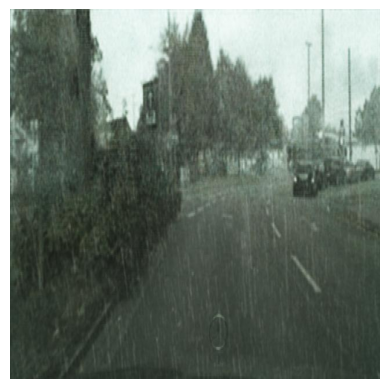

Question: startseq Are there pedestrians in front of the ego vehicle endseq
Actual Answer: startseq 0 pedestrains infront of ego vehicle at footpath. endseq
Predicted Answer: 0 pedestrains infront at footpath at footpath at footpath at footpath pedestrains infront at footpath at footpath at footpath pedestrains infront at



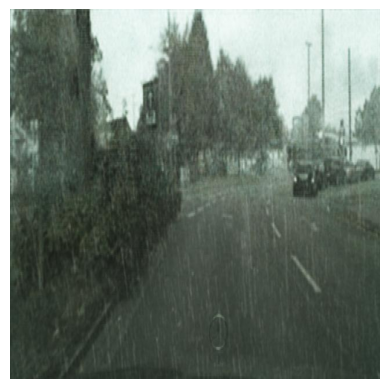

Question: startseq What are the objects in front of the ego vehicle endseq
Actual Answer: startseq There are 3 objects infront of the ego vehicle. endseq
Predicted Answer: there 3 infront at footpath at footpath at footpath pedestrains infront at footpath at footpath pedestrains infront at footpath



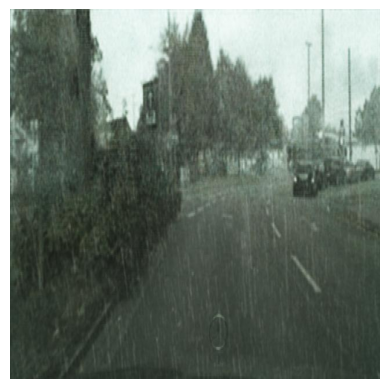

Question: startseq Are there any parking vehicles in front of the car endseq
Actual Answer: startseq There are 3 parked vehicles infront of the car endseq
Predicted Answer: 3 parked infront infront at right side at right side at right side



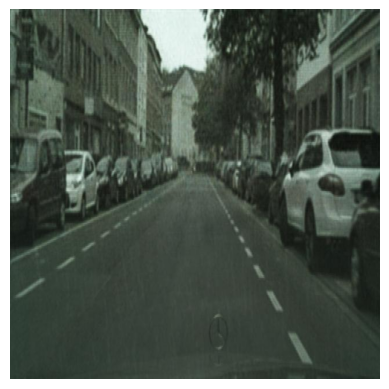

Question: startseq What is the current weather scenario? endseq
Actual Answer: startseq Cloudy endseq
Predicted Answer: scenario cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy cloudy infront cloudy cloudy vehicle vehicle vehicle



In [ ]:
def beam_search_predict(model, tokenizer, photo, question, max_length, beam_width=3):
    # Prepare the question sequence
    question_seq = tokenizer.texts_to_sequences(['startseq ' + question + ' endseq'])[0]
    question_seq = pad_sequences([question_seq], maxlen=max_length)[0]
    sequence = np.concatenate([question_seq, np.zeros(max_length)])

    sequences = [[list(sequence), 0.0]]  # Initial beam

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            seq_pad = pad_sequences([seq], maxlen=2 * max_length)
            yhat = model.predict([photo, seq_pad], verbose=0)[0]
            top_words = np.argsort(yhat)[::-1][:beam_width]

            for word in top_words:
                candidate = [seq + [word], score - np.log(yhat[word] + 1e-8)]
                all_candidates.append(candidate)

        sequences = sorted(all_candidates, key=lambda tup: tup[1])[:beam_width]

    best_seq = min(sequences, key=lambda tup: tup[1])[0]
    answer = ' '.join([tokenizer.index_word.get(i, '') for i in best_seq if i > 0])

    # Remove the question part from the predicted answer
    answer = answer.replace('startseq', '').replace('endseq', '').strip()

    # Remove any remaining question words and clean up the answer
    answer = clean_answer(answer, question)
    return answer

def clean_answer(answer, question):
    question_words = set(question.lower().split())
    answer_words = answer.lower().split()
    filtered_words = [word for word in answer_words if word not in question_words]
    return ' '.join(filtered_words).strip()

def generate_answer(model, tokenizer, photo, question, max_length):
    return beam_search_predict(model, tokenizer, photo, question, max_length)

def test_qa_model(test_features, test_questions, test_answers, model, tokenizer, max_length, image_paths, num_images=6):
    keys = list(test_features.keys())
    random.shuffle(keys)
    selected_keys = keys[:num_images]

    for key in selected_keys:
        photo = test_features[key]
        questions = test_questions.get(key, [])
        actual_answers = test_answers.get(key, [])

        for i, question in enumerate(questions):
            photo_features = np.expand_dims(photo, axis=0)
            predicted_answer = generate_answer(model, tokenizer, photo_features, question, max_length)
            cleaned_predicted_answer = clean_answer(predicted_answer, question)

            img_path = image_paths.get(key)
            if img_path:
                img = Image.open(img_path)
                plt.imshow(img)
                plt.axis('off')
                plt.show()

            actual_answer = actual_answers[i] if i < len(actual_answers) else 'N/A'
            print(f"Question: {question}")
            print(f"Actual Answer: {actual_answer}")
            print(f"Predicted Answer: {cleaned_predicted_answer}")
            print()

# Paths for image files
# Paths for image files
image_paths = {key: os.path.join(test_images_path, key) for key in test_features.keys()}

# Run the test
test_qa_model(test_features, test_questions, test_answers, qa_model, tokenizer, max_length, image_paths)